In [14]:
from pytorch3d.utils import ico_sphere
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform, 
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer, 
    TexturedSoftPhongShader,
    HardPhongShader
)
import torch
from matplotlib import pyplot as plt



tensor([[-0.5257,  0.8507,  0.0000],
        [ 0.5257,  0.8507,  0.0000],
        [-0.5257, -0.8507,  0.0000],
        ...,
        [-0.3996, -0.0823, -0.9130],
        [ 0.3996,  0.0823, -0.9130],
        [-0.3996,  0.0823, -0.9130]])
tensor([[  0, 166, 163],
        [  0, 163, 162],
        [  0, 162, 164],
        ...,
        [616, 617, 615],
        [636, 640, 637],
        [603, 604, 605]])


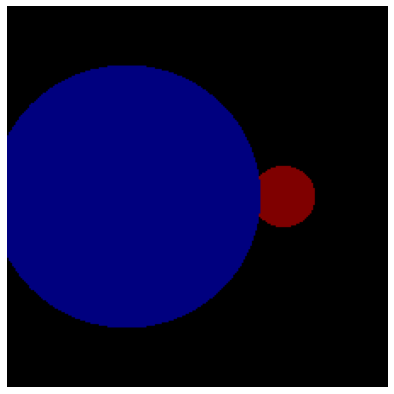

In [20]:
device = torch.device("cuda:0")
# Initialize two ico spheres of different sizes
mesh1 = ico_sphere(3)  # (42 verts, 80 faces)
mesh2 = ico_sphere(4)  # (162 verts, 320 faces)
verts1, faces1 = mesh1.get_mesh_verts_faces(0)
verts2, faces2 = mesh2.get_mesh_verts_faces(0)
print(verts1)
print(faces1)

# Initalize the textures as an RGB color per vertex
tex1 = torch.ones_like(verts1).cuda()
tex2 = torch.ones_like(verts2).cuda()
tex1[:, 1:] *= 0.0  # red
tex2[:, :2] *= 0.0  # blue

# Create one mesh which contains two spheres of different sizes.
# To do this we can concatenate verts1 and verts2
# but we need to offset the face indices of faces2 so they index
# into the correct positions in the combined verts tensor. 

# Make the red sphere smaller and offset both spheres so they are not overlapping
verts1 *= 0.25  
verts1[:, 0] += 0.7
verts2[:, 0] -= 0.5
verts = torch.cat([verts1, verts2]).cuda()  #(204, 3)

#  Offset by the number of vertices in mesh1
faces2 = faces2 + verts1.shape[0]  
faces = torch.cat([faces1, faces2]).cuda()  # (400, 3)

tex = torch.cat([tex1, tex2])[None]  # (1, 204, 3)
textures = Textures(verts_rgb=tex.cuda())

mesh = Meshes(verts=[verts], faces=[faces], textures=textures)

# Create a renderer
batch_size = 1
R, T = look_at_view_transform(dist=2.7, elev=0, azim=0)
R = R.repeat(batch_size, 1, 1)
T = T.repeat(batch_size, 1)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

raster_settings = RasterizationSettings(image_size=224, blur_radius=0.0, faces_per_pixel=1)
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings), shader=HardPhongShader(device=device, cameras=cameras, lights=lights))

# Render the mesh
image = renderer(mesh)   # (1, H, W, 4)
plt.figure(figsize=(7,7))
plt.imshow(image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis('off');